In [5]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
shape = (7,7,4)
som = np.random.rand(*shape)

# Training parameters
L0 = 0.8
lam = 1e2
sigma0 = 5

# load iris dataset
dataset = pd.read_csv('E:/Academic/Neural Networks/Assignment_2/iris.txt', delimiter=',', names = ['a','b','c','d','y'])
data = dataset.iloc[:,0:4].values
Y = dataset.iloc[:,4].values

In [21]:
def sigma(t):
    """
    Neighbouring radius formula.
    t: current time.
    """
    return sigma0*np.exp(-t/lam)

def find_bmu(input_vec):
    """
        Find the Best Matching Unit of a given input vector.
        input_vec: a d=dim_feat=self.shape[2] input vector.
    """
    list_bmu = []
    for y in range(shape[0]):
        for x in range(shape[1]):
            dist = np.linalg.norm((input_vec-som[y,x]))
            list_bmu.append(((y,x),dist))
    list_bmu.sort(key=lambda x: x[1])
    return list_bmu[0][0]

def update_bmu(bmu,input_vector,t):
    """
        Update rule for the BMU.
        bmu: (y,x) BMU's coordinates.
        input_vector: current data vector.
        t: current time.
    """
    som[bmu] += L(t)*(input_vector-som[bmu])
    
def update_som(bmu,input_vector,t):
    """ 
        Calls the update rule on each cell.
        bmu: (y,x) BMU's coordinates.
        input_vector: current data vector.
        t: current time.
    """
    for y in range(shape[0]):
        for x in range(shape[1]):
            dist_to_bmu = np.linalg.norm((np.array(bmu)-np.array((y,x))))
            update_cell((y,x),dist_to_bmu,input_vector,t)

def update_cell(cell,dist_to_bmu,input_vector,t):
    """ 
        Computes the update rule on a cell.
        cell: (y,x) cell's coordinates.
        dist_to_bmu: L2 distance from cell to bmu.
        input_vector: current data vector.
        t: current time.
    """
    som[cell] += N(dist_to_bmu,t)*L(t)*(input_vector-som[cell])
    
def N(dist_to_bmu,t):
    """ 
        Computes the neighbouring penalty.
        dist_to_bmu: L2 distance to bmu.
        t: current time.
    """
    curr_sigma = sigma(t)
    return np.exp(-(dist_to_bmu**2)/(2*curr_sigma**2))

def sigma(t):
    """
        Neighbouring radius formula.
        t: current time.
    """
    return sigma0*np.exp(-t/lam)

def L(t):
    """
        Learning rate formula.
        t: current time.
    """
    return L0*np.exp(-t/lam)

def get_bmu():
    """ 
        Get the BMU list of the SOM.
        It uses the data fed at last training.
    """
    bmu_list = []
    for input_vector in data:
        bmu = find_bmu(input_vector)
        bmu_list.append(bmu)

    return bmu_list

def train():
    for t in itertools.count():
        if sigma(t) < 1.0:
            break

        i_data =  np.random.choice(range(len(data)))

        bmu = find_bmu(data[i_data])
        update_som(bmu,data[i_data],t)

In [22]:
train()
bmu_list = get_bmu()

In [24]:
temp_dataset = dataset
temp_dataset['cluster'] = bmu_list

In [25]:
#group all iris data tuples per bmu (best matching unit) and extract most frequent target associated to each cell
#resulting object is in descending order so that the first element is the most frequently-occurring class label in value_counts
df = temp_dataset.groupby('cluster')['y'].value_counts().reset_index(name='v')
df = df.drop_duplicates('cluster')[['cluster','y']].reset_index(drop=True)

In [27]:
#initilaize majority matrix
result_map = np.zeros([7,7],dtype=np.int)

# fill majority matrix with the most frequently-occurring class label
counter = 0
for i in range(len(result_map)):
    for j in range(len(result_map[i])):
        if len(df[df['cluster'] == (i,j)]) == 0:
            result_map[i][j] = 0
        else:
            result_map[i][j] = df[df['cluster'] == (i,j)]['y'][counter]
            counter += 1

In [28]:
result_map

array([[0, 0, 0, 1, 1, 1, 1],
       [2, 2, 0, 0, 0, 1, 1],
       [2, 0, 2, 0, 0, 0, 0],
       [2, 3, 2, 2, 2, 2, 0],
       [3, 3, 3, 2, 2, 2, 2],
       [3, 3, 3, 3, 0, 2, 2],
       [3, 3, 3, 3, 2, 2, 2]])

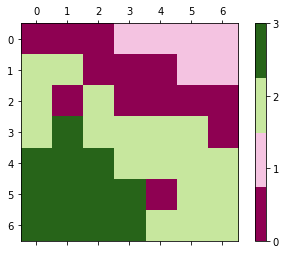

In [30]:
fig = plt.figure()
subplot = fig.add_subplot(111)
#get discrete colormap
cmap = plt.get_cmap('PiYG', 4)
cax = subplot.matshow(result_map, cmap=cmap)
fig.colorbar(cax, ticks=np.arange(0,4))
plt.show()